In [1]:
#%% IMPORTS 

import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:

#%% PREPROCESSIN

def preprocess_sensor_space_data(subject, date, raw_path,
                                 event_id=dict(
                                            ipos = 21,
                                            ipos_wneu = 41,
                                            ineg = 22,
                                            ineg_wneu = 42,
                                            wpos = 11,
                                            wneg = 12,
                                            wneu = 13
                                            ),
                                 h_freq=40,
                                 tmin=-0.200, tmax=0.500, baseline=(None, 0),
                                 reject=None, decim=1,
                                 return_epochs=False,
                                 ):
    n_recordings = 6
    epochs_list = list()
    for recording_index in range(n_recordings): # ## loop from 0 to 5
        fif_index = recording_index + 1 # files are not 0-indexed
        fif_fname = 'face_word_' + str(fif_index) 
        if subject == '0085': ## sonething went wrong with the first three rec.
            folder_name = '00' + str(fif_index + 3) + '.' + fif_fname
        else:
            folder_name = '00' + str(fif_index) + '.' + fif_fname # HERE A CRUCIAL DOT WAS ADDED
            
        full_path = join(raw_path, subject, date, 'MEG', folder_name,
                         'files', fif_fname + '.fif')
        raw = mne.io.read_raw(full_path, preload=True)
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=4)
        
        events = mne.find_events(raw, min_duration=0.002)
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,
                            preload=True, decim=decim)
        epochs.pick_types(meg=True)
        if return_epochs:
            epochs_list.append(epochs)
        else:
            if recording_index == 0:
                X = epochs.get_data()
                y = epochs.events[:, 2]
            else:
                X = np.concatenate((X, epochs.get_data()), axis=0)
                y = np.concatenate((y, epochs.events[:, 2]))
    
    if return_epochs:
        return epochs_list
    else:
        return X, y

def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list=None,
                              event_id=dict(ipos = 21,
                                            ipos_wneu = 41,
                                            ineg = 22,
                                            ineg_wneu = 42,
                                            wpos = 11,
                                            wneg = 12,
                                            wneu = 13
                                            ),
                              h_freq=40,
                              tmin=-0.200, tmax=0.500, baseline=(None, 0),
                              reject=None, decim=1,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label= None): ####### HERE
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path)
    
    for epochs_index, epochs in enumerate(epochs_list): ## get X
        fwd_fname = 'face_word_' + str(epochs_index + 1) + '-oct-6-src-' + \
                    '5120-5120-5120-fwd.fif'
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                     method, label,
                                                     pick_ori=pick_ori)
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data
            if epochs_index == 0 and stc_index == 0:
                n_trials = len(stcs)
                n_vertices, n_samples = this_data.shape
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

In [ ]:
# creating epochs_list 
epochs_list = preprocess_sensor_space_data('0095', '20221007_000000',
        raw_path='/work/220269/raw_MEG/',
        return_epochs=True, decim=4) ##CHANGE TO YOUR PATHS

In [ ]:
#%% RUNNING FUNCTIONS ##### ROI ## preprocess_source_space_data function
X_BA45_lh, y = preprocess_source_space_data(
        '0095', '20221007_000000', 
        raw_path='/work/220269/raw_MEG', 
        subjects_dir = '/work/220269/freesurfer/',
        epochs_list = epochs_list,
        label= 'lh.BA45_exvivo.label')
        #,decim=4

        # freesurfer labels
        # lh.BA45_exvivo.label
        # lh.B44_exvivo.label
        # rh.fusiform.label
        # lh.fusiform.label

In [73]:
#%% COLLAPSE EVENTS - single subject

def collapse_events(y, new_value, old_values=list()):
    for old_value in old_values:
        y[y == old_value] = new_value
    return y

collapsed_y = collapse_events(y, 0, [21, 41, 22, 42]) # image is 0
collapsed_y = collapse_events(collapsed_y, 1, [11, 12, 13]) # word is 1 

collapsed_y.shape

(720,)

In [74]:
X_BA45_lh.shape # 720, 93, 176

# par 89 har 720, 111, 176
# par 95 har 720, 110, 176

(720, 110, 176)

In [75]:
# looking at the details of the participant in question
epochs_list[0]

Number of events,120
Events,ineg: 20ineg_wneu: 11ipos: 20ipos_wneu: 9wneg: 20wneu: 20wpos: 20
Time range,-0.200 – 0.500 sec
Baseline,-0.200 – 0.000 sec


## Classification

In [8]:

#%% SIMPLE CLASSIFICATION

def simple_classification(X, y, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=-1)
        mean_scores[sample_index] = np.mean(scores)
        print(sample_index)
        
    return mean_scores

In [ ]:
# Defining ROI's #1
# fusiform face area; concatenate right and left lh.fusiform.label + rh.fusiform.label

X_fusiform_both = np.concatenate((X_fusiform_lh,
                                              X_fusiform_rh), axis=1)

# run classification
mean_scores_fu_both = simple_classification(X_fusiform_both,
                                    collapsed_y,
                                    penalty='l2', C=1e-3)

In [ ]:
# Defining ROI's #2
# Broca's area; both BA44 and BA45

# concatenate labels
X_BA44_BA45_lh = np.concatenate((X_BA44_lh, X_BA45_lh), axis = 1)

# run classification
mean_scores_BA = simple_classification(X_BA44_BA45_lh, collapsed_y, penalty = 'l2', C=1e-3)

In [77]:
##### change participant number! to be used when plotting, saving files, etc.
par_no = 95

In [ ]:
# create dataframe, change column name and write to csv
df = pd.DataFrame(mean_scores_BA) 
df.columns = ['par_%s' % (par_no)]
print(df)

In [79]:
# write to csv
df.to_csv("mean_scores/mean_scores_BA44_BA45_lh_%s.csv" % (par_no), index = False)

In [ ]:
# # # initialize df
# BA44_BA45_all_participants = pd.DataFrame()
# print(BA44_BA45_all_participants)

In [ ]:
## if df has already been initialized, read instead 
#BA44_BA45_all_participants = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/BA44_BA45_all_participants.csv")

In [ ]:
# append df to big dataframe
BA44_BA45_all_participants = pd.concat([BA44_BA45_all_participants, df], axis = 1)

# check that it looks alright - it does
BA44_BA45_all_participants

In [81]:
# write to csv
BA44_BA45_all_participants.to_csv("BA44_BA45_all_participants.csv", index = False)

In [ ]:
# read the csv and check that it is saved
test = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/BA44_BA45_all_participants.csv")
test

### Classification plot

In [90]:
#%% PLOT 

# times = epochs_list[0].times
# times = np.arange(-0.200, 0.501, 0.001)
    
def plot_classfication(times, mean_scores, fig_name, title=None, subtitle = None, save_fig = False):
    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        plt.title('please write a title')
    else:
        plt.title(title)

    if subtitle is None: 
        plt.suptitle('test')
    else:
        plt.suptitle(subtitle)

    # saving fig
    if save_fig:
        path = "figures/"
        fig_name_here = join(fig_name + "%s" + ".png") % (par_no)
        #fig_name_here = join(fig_name + "all_par" + ".png") # to be used when making a plot for all participants
        plt.savefig(path + fig_name_here)
    plt.show()


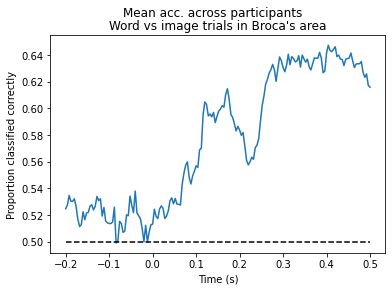

In [89]:
# run plot function
plot_classfication(
    epochs_list[0].times, 
    #BA44_BA45_all_participants.iloc[:,6], # to be used when plotting the mean accuracy across participants
    mean_scores_BA,
    fig_name = "BA44_BA45_lh_",
    title = "Word vs image trials in Broca's area", 
    subtitle = "Participant %s" % (par_no),
    #subtitle = 'Mean acc. across participants',
    save_fig = True)


### Add mean column to dataframe

In [ ]:
# Create mean column in the big df of classification accuracies
BA44_BA45_all_participants['mean'] = BA44_BA45_all_participants.mean(axis = 1)
print(BA44_BA45_all_participants)

In [85]:
# save to csv
BA44_BA45_all_participants.to_csv("BA44_BA45_all_participants.csv", index = False)

In [ ]:
# read the csv to check that it is saved
test = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/BA44_BA45_all_participants.csv")
test

Then, plot again.

#### Calculating a mean of classification accuracy for baseline and for after showing the stimulus

In [96]:
# read a given file of accuracy scores to see how many rows we have
BA44_BA44_par95 = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/mean_scores/mean_scores_BA44_BA45_lh_95.csv")
print(BA44_BA44_par95)

We have 176 rows. Now we need to figure out how many rows, or classification accuracies, we have before and after the onset of the stim.

In [98]:
epochs_list[0].baseline

(-0.2, 0.0)

All the classification accuracies which are more than or equal to zero are from when or after the stimulus is shown.

In [99]:
# make a list which states whether the timestamp is more than or equal to zero
to_include = epochs_list[0].times >= 0
print(to_include)

In [101]:
# count the number of true values
np.count_nonzero(to_include)

126

126 classification accuracies after stim onset. which leaves us with:

In [102]:
176-126

50

50 classification accuracies before stim onset. now to calculate the mean before and after stim onset

In [103]:
BA = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/BA44_BA45_all_participants.csv")
fus = pd.read_csv("/work/SigridAgersnapBomNielsen#1365/MEG_data_analysis/fusiform_both_all_participants.csv")

select the first 50 rows to calculate a mean before stim onset

In [104]:
BA_50 = BA.head(50)
BA_mean_before_stim = BA_50["mean"].mean()
round(BA_mean_before_stim, 2) #mean before stim is 0.52

0.52

select the last 126 rows to calculate a mean after stim onset

In [105]:
BA_126 = BA.tail(126)
BA_mean_after_stim = BA_126["mean"].mean()
round(BA_mean_after_stim, 2) # mean after stim onset is 0.6

0.6

Now the same, but for the fusiform gyri

In [415]:
fus_50 = fus.head(50)
fus_mean_before_stim = fus_50["mean"].mean()
round(fus_mean_before_stim, 2) # mean before stim is 0.52

0.52

In [416]:
fus_126 = fus.tail(126)
fus_mean_after_stim = fus_126["mean"].mean()
round(fus_mean_after_stim, 2) # mean after stim onset is 0.69

0.69

# Permutation test

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import permutation_test_score

In [106]:
# indledende øvelser fra simple class function (need to do it again, because it only functions locally in a function)
X = X_BA44_BA45_lh.copy()

n_samples = X.shape[2]

#standardizing the X
sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    
for sample_index in range(n_samples):
    this_X = X[:, :, sample_index]
    sc.fit(this_X)
    this_X_std = sc.transform(this_X)

# calculating the permutation test score
score, permutation_scores, pvalue = permutation_test_score(
    LogisticRegression(penalty="l2", C=1e-3, solver='newton-cg'),
    this_X_std, collapsed_y, cv=StratifiedKFold(), n_permutations=1000, 
    n_jobs=1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score, pvalue))

Classification Accuracy: 0.6277777777777778 (pvalue : 0.000999000999000999)


In [107]:
# checking stuff
print(score)
print(pvalue)
print(par_no)

0.6277777777777778
0.000999000999000999
95


In [ ]:
# # create a pd dataframe which saves participant number, classification accuracy score and p-value
# # ONLY RUN THIS THE FIRST TIME
# df_perm = pd.DataFrame({'participant' : [par_no],
#                     'class_acc': [score],
#                     'permutation_p_val': [pvalue]})
# print(df_perm)

In [ ]:
## when the df has been initialized, read it to append more participants
# df_perm = pd.read_csv("mean_scores/df_perm_BA44_BA45.csv")
# print(df_perm)

In [108]:
# append new values to df
temp = pd.DataFrame({'participant' : [par_no],
                    'class_acc': [score],
                    'permutation_p_val': [pvalue]})

df_perm = df_perm.append(temp, ignore_index=True)
print(df_perm)

   participant  class_acc  permutation_p_val
0           85   0.579167           0.000999
1           86   0.606944           0.000999
2           87   0.638889           0.000999
3           88   0.651389           0.000999
4           89   0.591667           0.000999
5           95   0.627778           0.000999


/tmp/ipykernel_280/1048796819.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_perm = df_perm.append(temp, ignore_index=True)


In [109]:
# save df
df_perm.to_csv("mean_scores/df_perm_BA44_BA45.csv", index = False)

In [110]:
# testing - it works
test = pd.read_csv("mean_scores/df_perm_BA44_BA45.csv")
print(test)

   participant  class_acc  permutation_p_val
0           85   0.579167           0.000999
1           86   0.606944           0.000999
2           87   0.638889           0.000999
3           88   0.651389           0.000999
4           89   0.591667           0.000999
5           95   0.627778           0.000999


df = pd.DataFrame({'points': [10, 12, 12, 14, 13, 18],
                   'rebounds': [7, 7, 8, 13, 7, 4],
                   'assists': [11, 8, 10, 6, 6, 5]})

### Save X_std and collapsed y per participant

In [111]:
# save X_std ######### 
np.savetxt("preprocessed_data/X_BA44_BA45_lh_std_%s.csv" % (par_no), this_X_std, delimiter=",")

In [175]:
# save y_collapsed ###### 
#np.savetxt("preprocessed_data/collapsed_y%s.csv" % (par_no), collapsed_y, delimiter = ",")

In [138]:
#testing that it works - it does
from numpy import genfromtxt

test = genfromtxt('preprocessed_data/collapsed_y_85.csv', delimiter=',')


(720,)


### Permutation plot

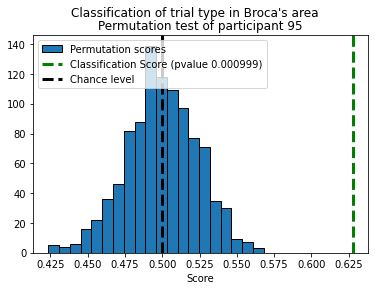

In [112]:
#How many classes
n_classes = np.unique(collapsed_y).size

# round p val
pvalue = round(pvalue,7)

plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title("Permutation test of participant %s" % (par_no))
plt.suptitle("Classification of trial type in Broca's area")
savefig_here = "figures/BA44_BA45_lh_%s_permutation.png" % (par_no)
plt.savefig(savefig_here)

plt.show()